<a href="https://colab.research.google.com/github/Sabelz/Master_Thesis_Alexander/blob/main/GPs/PowerGPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes on the Power Plant dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master_Thesis_Alexander
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Master_Thesis_Alexander


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2
%run "datasets/power.ipynb" # Run the Power notebook
%run "utils/models.ipynb" # Run the models notebook
%run "utils/functions.ipynb" # Run the functions notebook

# Set the seed for NumPy's random number generator
np.random.seed(0)

torch.manual_seed(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

# Prepare The Data

In [3]:
powerPlant_data = df_PowerPlant # df_PowerPlant is defined in ../datasets/power.ipynb
# The last column is output(net hourly electrical energy output (EP)  of the plant)
x_power, y_power = powerPlant_data.iloc[:, :-1].to_numpy() , powerPlant_data.iloc[:, -1].to_numpy()


x_train_power, x_test_power, y_train_power, y_test_power = train_test_split(x_power, y_power, test_size=0.2, random_state=666)
# Transform into tensors
x_train_power, x_test_power, y_train_power, y_test_power = (
torch.from_numpy(x_train_power).float(), torch.from_numpy(x_test_power).float(),
torch.from_numpy(y_train_power).float(), torch.from_numpy(y_test_power).float())

# Standardized data
scaler = StandardScaler()
x_train_power_standardized = torch.from_numpy(scaler.fit_transform(x_train_power)).float()
# Use the same scaler that was used on training data
x_test_power_standardized = torch.from_numpy(scaler.transform(x_test_power)).float()

if torch.cuda.is_available():
    x_train_power, y_train_power, x_test_power, y_test_power, x_train_power_standardized, x_test_power_standardized = (
    x_train_power.cuda(), y_train_power.cuda(), x_test_power.cuda(), y_test_power.cuda(),
    x_train_power_standardized.cuda(), x_test_power_standardized.cuda())

# Train data into batches
#train_dataset_power = TensorDataset(x_train_power, y_train_power)
#train_loader_power = DataLoader(train_dataset_power, batch_size=500, shuffle=True)

# Test data into batches
#test_dataset_power = TensorDataset(x_test_power, y_test_power)
#test_loader_power = DataLoader(test_dataset_power, batch_size=500, shuffle=False)

# Standardized batches
# Train data into batches
#train_dataset_power_standardized = TensorDataset(x_train_power_standardized, y_train_power)
#train_loader_power_standardized = DataLoader(train_dataset_power_standardized, batch_size=500, shuffle=True)

# Test data into batches
#test_dataset_power_standardized = TensorDataset(x_test_power_standardized, y_test_power)
#test_loader_power_standardized = DataLoader(test_dataset_power_standardized, batch_size=500, shuffle=False)

# Define the KISS-GP Model

In [4]:
KISSGP_likelihood_power = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_power = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_power = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_power = KISSGP_NDim(x_train_power,
                                 y_train_power,
                                 KISSGP_likelihood_power,
                                 KISSGP_mean_power,
                                 KISSGP_kernel_power) # KISSGP defined in utils/Models.ipynb
KISSGP_model_power = KISSGP_model_power.to(device) # Move model to device.

# One with standardized features
KISSGP_likelihood_power_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_power_standardized = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_power_standardized = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_power_standardized = KISSGP_NDim(x_train_power_standardized,
                                              y_train_power,
                                              KISSGP_likelihood_power_standardized,
                                              KISSGP_mean_power_standardized,
                                              KISSGP_kernel_power_standardized) # KISSGP defined in utils/Models.ipynb
KISSGP_model_power_standardized = KISSGP_model_power_standardized.to(device) # Move model to device.

# Train and Evaluate the KISS-GP Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  res = cls(index_tensor, value_tensor, interp_size)


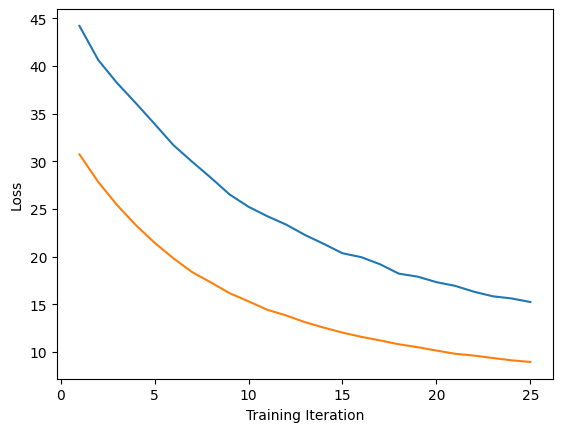

In [5]:
train_time_KISSGP_power = train(KISSGP_model_power,
                          KISSGP_likelihood_power,
                          x_train_power,
                          y_train_power,
                          training_iter= 25) # train is defined in utils/functions.ipynb
# Standardized version
train_time_KISSGP_power_standardized = train(KISSGP_model_power_standardized,
                                       KISSGP_likelihood_power_standardized,
                                       x_train_power_standardized,
                                       y_train_power,
                                       training_iter= 25) # train is defined in utils/functions.ipynb

In [6]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_power = predict(KISSGP_model_power, KISSGP_likelihood_power,
                                     x_test_power) # predict is defined in utils/functions.ipynb
  RMSE_KISSGP_power, NLPD_KISSGP_power, PICP_KISSGP_power, MPIW_KISSGP_power = error_metrics(
      x_test_power,
      y_test_power,
      predictions_KISSGP_power.mean,
      predictions_KISSGP_power.variance)# error_metrics defined in utils/functions.ipynb


  # Standardized version
  predictions_KISSGP_power_standardized = predict(KISSGP_model_power_standardized, KISSGP_likelihood_power_standardized,
                                                  x_test_power_standardized) # predict is defined in utils/functions.ipynb

  RMSE_KISSGP_power_standardized, NLPD_KISSGP_power_standardized, PICP_KISSGP_power_standardized, MPIW_KISSGP_power_standardized = error_metrics(
      x_test_power_standardized,
      y_test_power,
      predictions_KISSGP_power_standardized.mean,
      predictions_KISSGP_power_standardized.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE KISS-GP: ",RMSE_KISSGP_power)
  print("NLPD KISS-GP: ",NLPD_KISSGP_power)
  print("PICP KISS-GP: ",PICP_KISSGP_power)
  print("MPIW KISS-GP: ",MPIW_KISSGP_power)
  print("Time KISS-GP: ", train_time_KISSGP_power)

  print("RMSE KISS-GP Standardized: ",RMSE_KISSGP_power_standardized)
  print("NLPD KISS-GP Standardized: ",NLPD_KISSGP_power_standardized)
  print("PICP KISS-GP Standardized: ",PICP_KISSGP_power_standardized)
  print("MPIW KISS-GP Standardized: ",MPIW_KISSGP_power_standardized)
  print("Time KISS-GP Standardized: ", train_time_KISSGP_power_standardized)

RMSE KISS-GP:  4.344788
NLPD KISS-GP:  5.696587085723877
PICP KISS-GP:  0.49738766980146293
MPIW KISS-GP:  5.771711
Time KISS-GP:  168.25220131874084
RMSE KISS-GP Standardized:  5.1393127
NLPD KISS-GP Standardized:  7.356102466583252
PICP KISS-GP Standardized:  0.4038662486938349
MPIW KISS-GP Standardized:  5.791737
Time KISS-GP Standardized:  128.40497756004333


# Variational Distribution Model

In [7]:
variational_likelihood_power = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_power = gpytorch.means.ConstantMean()
variational_kernel_power = gpytorch.kernels.RBFKernel()
n_inducing_points = int(len(x_train_power)/10)
# Generate a tensor of random indices
indices = torch.randperm(x_train_power.size(0))
# Select N random rows
inducing_points = x_train_power[indices][:n_inducing_points]
variational_model_power = variationalGP(variational_likelihood_power,
                                        variational_mean_power,
                                        variational_kernel_power,
                                        inducing_points) # InducingGP defined in utils/models.ipynb
variational_model_power = variational_model_power.to(device) # Move model to device, defined in utils/models.ipynb

# Standardized version
variational_likelihood_power_standardized = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_power_standardized = gpytorch.means.ConstantMean()
variational_kernel_power_standardized = gpytorch.kernels.RBFKernel()
n_inducing_points = int(len(x_train_power)/10)
# Generate a tensor of random indices
indices = torch.randperm(x_train_power_standardized.size(0))
# Select N random rows
inducing_points_standardized = x_train_power_standardized[indices][:n_inducing_points]
variational_model_power_standardized = variationalGP(variational_likelihood_power_standardized,
                                               variational_mean_power_standardized,
                                               variational_kernel_power_standardized,
                                               inducing_points_standardized) # InducingGP defined in utils/models.ipynb
variational_model_power_standardized = variational_model_power_standardized.to(device) # Move model to device, defined in utils/models.ipynb

# Train and Evaluate Variational Model

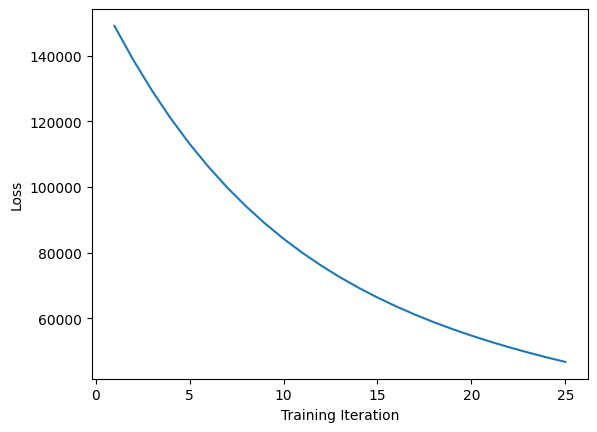

In [8]:
# Use train_loader_power
train_time_variational_power = train_ELBO(variational_model_power,
                                 variational_likelihood_power,
                                 x_train_power,
                                 y_train_power,
                                 training_iter= 25) # train is defined in utils/functions.ipynb



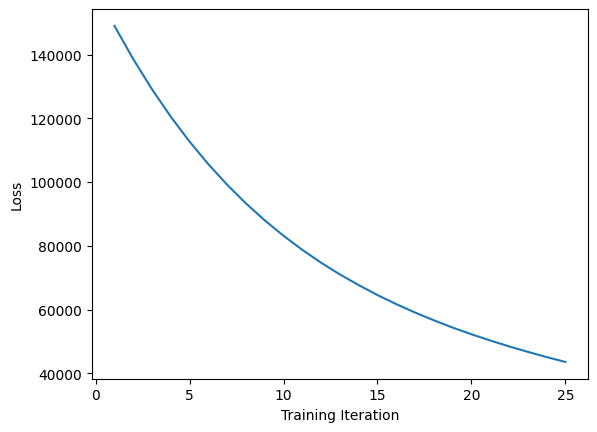

In [9]:
# Standardized version, train_loader_power_standardized
train_time_variational_power_standardized = train_ELBO(variational_model_power_standardized,
                                              variational_likelihood_power_standardized,
                                              x_train_power_standardized,
                                              y_train_power,
                                              training_iter= 25) # train is defined in utils/functions.ipynb

In [10]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # predict is defined in utils/functions.ipynb
  predictions_variational_power = predict(variational_model_power, variational_likelihood_power, x_test_power)

  RMSE_variational_power, NLPD_variational_power, PICP_variational_power, MPIW_variational_power = error_metrics(
      x_test_power,
      y_test_power,
      predictions_variational_power.mean,
      predictions_variational_power.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model: ",RMSE_variational_power)
  print("NLPD variational Model: ",NLPD_variational_power)
  print("PICP variational Model: ",PICP_variational_power)
  print("MPIW variational Model: ",MPIW_variational_power)
  print("Time variational Model: ", train_time_variational_power)

  # Standardized version
  predictions_variational_power_standardized = predict(variational_model_power_standardized,
                                       variational_likelihood_power_standardized,
                                       x_test_power_standardized)

  RMSE_variational_power_standardized, NLPD_variational_power_standardized, PICP_variational_power_standardized, MPIW_variational_power_standardized = error_metrics(
      x_test_power_standardized,
      y_test_power,
      predictions_variational_power_standardized.mean,
      predictions_variational_power_standardized.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model Standardized: ",RMSE_variational_power_standardized)
  print("NLPD variational Model Standardized: ",NLPD_variational_power_standardized)
  print("PICP variational Model Standardized: ",PICP_variational_power_standardized)
  print("MPIW variational Model Standardized: ",MPIW_variational_power_standardized)
  print("Time variational Model Standardized: ", train_time_variational_power_standardized)

RMSE variational Model:  447.03748
NLPD variational Model:  29006.80859375
PICP variational Model:  0.0
MPIW variational Model:  7.3464255
Time variational Model:  1063.313018321991
RMSE variational Model Standardized:  429.20963
NLPD variational Model Standardized:  30023.6171875
PICP variational Model Standardized:  0.0
MPIW variational Model Standardized:  7.237618
Time variational Model Standardized:  81.80030703544617


# Inducing Points Model

In [11]:
inducing_likelihood_power = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_power = gpytorch.means.ConstantMean() # Mean
inducing_kernel_power = gpytorch.kernels.RBFKernel() # Kernel
# Choose random inital inducing points
# Generate a tensor of random indices
indices = torch.randperm(x_train_power.size(0))
# Select N random rows
inducing_points_amount = int(len(x_train_power)/10) # Around half of the points
inducing_points = x_train_power[indices][:inducing_points_amount]
inducing_model_power = inducingGP(x_train_power,
                                 y_train_power,
                                 inducing_likelihood_power,
                                 inducing_mean_power,
                                 inducing_kernel_power,
                                 inducing_points) # inducingGP defined in utils/Models.ipynb

inducing_model_power = inducing_model_power.to(device) # Move model to device.

# One with standardized features
inducing_likelihood_power_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_power_standardized = gpytorch.means.ConstantMean() # Mean
inducing_kernel_power_standardized = gpytorch.kernels.RBFKernel() # Kernel
# Generate a tensor of random indices
indices = torch.randperm(x_train_power_standardized.size(0))
# Select N random rows
inducing_points_standardized = x_train_power_standardized[indices][:inducing_points_amount]
inducing_model_power_standardized = inducingGP(x_train_power_standardized,
                                              y_train_power,
                                              inducing_likelihood_power_standardized,
                                              inducing_mean_power_standardized,
                                              inducing_kernel_power_standardized,
                                              inducing_points_standardized) # inducingGP defined in utils/Models.ipynb

inducing_model_power_standardized = inducing_model_power_standardized.to(device) # Move model to device.

# Train and evaluate the inducing model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


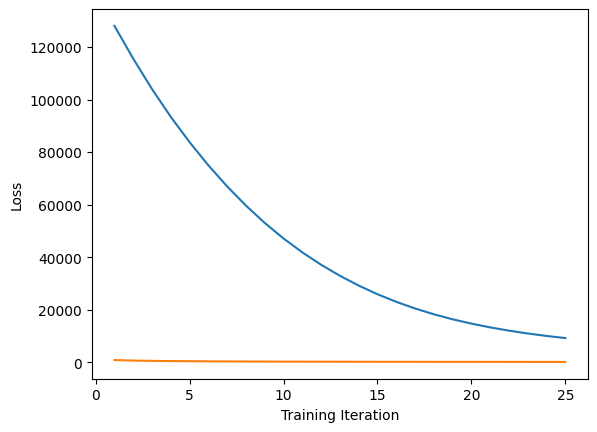

In [12]:
train_time_inducing_power = train(inducing_model_power,
                          inducing_likelihood_power,
                          x_train_power,
                          y_train_power,
                          training_iter= 25) # train is defined in utils/functions.ipynb
# Standardized version
train_time_inducing_power_standardized = train(inducing_model_power_standardized,
                                       inducing_likelihood_power_standardized,
                                       x_train_power_standardized,
                                       y_train_power,
                                       training_iter= 25) # train is defined in utils/functions.ipynb

In [13]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_inducing_power = predict(inducing_model_power, inducing_likelihood_power,
                                     x_test_power) # predict is defined in utils/functions.ipynb
  RMSE_inducing_power, NLPD_inducing_power, PICP_inducing_power, MPIW_inducing_power = error_metrics(
      x_test_power,
      y_test_power,
      predictions_inducing_power.mean,
      predictions_inducing_power.variance)# error_metrics defined in utils/functions.ipynb


  # Standardized version
  predictions_inducing_power_standardized = predict(inducing_model_power_standardized, inducing_likelihood_power_standardized,
                                                  x_test_power_standardized) # predict is defined in utils/functions.ipynb

  RMSE_inducing_power_standardized, NLPD_inducing_power_standardized, PICP_inducing_power_standardized, MPIW_inducing_power_standardized = error_metrics(
      x_test_power_standardized,
      y_test_power,
      predictions_inducing_power_standardized.mean,
      predictions_inducing_power_standardized.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE inducing: ",RMSE_inducing_power)
  print("NLPD inducing: ",NLPD_inducing_power)
  print("PICP inducing: ",PICP_inducing_power)
  print("MPIW inducing: ",MPIW_inducing_power)
  print("Time inducing: ", train_time_inducing_power)

  print("RMSE inducing Standardized: ",RMSE_inducing_power_standardized)
  print("NLPD inducing Standardized: ",NLPD_inducing_power_standardized)
  print("PICP inducing Standardized: ",PICP_inducing_power_standardized)
  print("MPIW inducing Standardized: ",MPIW_inducing_power_standardized)
  print("Time inducing Standardized: ", train_time_inducing_power_standardized)

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


RMSE inducing:  152.45444
NLPD inducing:  4179.275390625
PICP inducing:  0.048589341692789965
MPIW inducing:  6.1510215
Time inducing:  800.5505874156952
RMSE inducing Standardized:  7.6699166
NLPD inducing Standardized:  17.894119262695312
PICP inducing Standardized:  0.33699059561128525
MPIW inducing Standardized:  5.1592216
Time inducing Standardized:  35.30077767372131


# Exact Gaussian Process Model

In [14]:
exact_likelihood_power = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
exact_mean_power = gpytorch.means.ConstantMean() # Mean
exact_kernel_power = gpytorch.kernels.MaternKernel() # Kernel
exact_model_power = exactGP(x_train_power,
                             y_train_power,
                             exact_likelihood_power,
                             exact_mean_power,
                             exact_kernel_power) # exactGP defined in utils/Models.ipynb
exact_model_power = exact_model_power.to(device) # Move model to device, defined in utils/models.ipynb


# Standardized version

exact_likelihood_power_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
exact_mean_power_standardized = gpytorch.means.ConstantMean() # Mean
exact_kernel_power_standardized = gpytorch.kernels.MaternKernel() # Kernel
exact_model_power_standardized = exactGP(x_train_power_standardized,
                             y_train_power,
                             exact_likelihood_power_standardized,
                             exact_mean_power_standardized,
                             exact_kernel_power_standardized) # exactGP defined in utils/Models.ipynb
exact_model_power_standardized = exact_model_power_standardized.to(device) # Move model to device, defined in utils/models.ipynb

# Train The Model

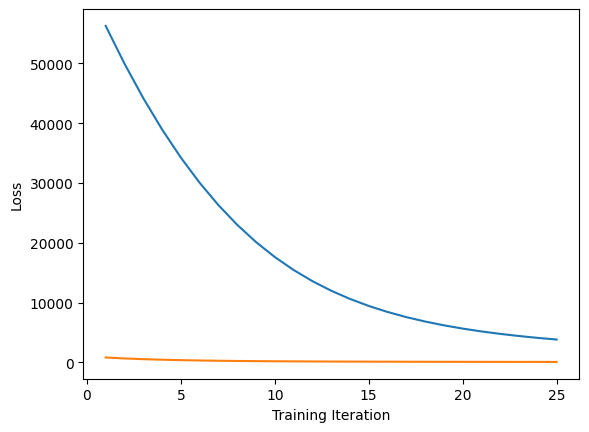

In [15]:
train_time_exact_power = train(exact_model_power,
                                 exact_likelihood_power,
                                 x_train_power,
                                 y_train_power,
                                 training_iter= 25) # train is defined in utils/functions.ipynb



train_time_exact_power_standardized = train(exact_model_power_standardized,
                                 exact_likelihood_power_standardized,
                                 x_train_power_standardized,
                                 y_train_power,
                                 training_iter= 25) # train is defined in utils/functions.ipynb

# Evaluate Exact-GP

In [16]:

# Evaluate
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_exact_power = predict(exact_model_power, exact_likelihood_power,
                                     x_test_power) # predict is defined in utils/functions.ipynb
  RMSE_exact_power, NLPD_exact_power, PICP_exact_power, MPIW_exact_power = error_metrics(
      x_test_power,
      y_test_power,
      predictions_exact_power.mean,
      predictions_exact_power.variance)# error_metrics defined in utils/functions.ipynb


# Standardized
# Evaluate
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_exact_power_standardized = predict(exact_model_power_standardized, exact_likelihood_power_standardized,
                                     x_test_power_standardized) # predict is defined in utils/functions.ipynb
  RMSE_exact_power_standardized, NLPD_exact_power_standardized, PICP_exact_power_standardized, MPIW_exact_power_standardized = error_metrics(
      x_test_power_standardized,
      y_test_power,
      predictions_exact_power_standardized.mean,
      predictions_exact_power_standardized.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE Exact-GP: ",RMSE_exact_power)
  print("NLPD Exact-GP: ",NLPD_exact_power)
  print("PICP Exact-GP: ",PICP_exact_power)
  print("MPIW Exact-GP: ",MPIW_exact_power)
  print("Time Exact-GP: ", train_time_exact_power)


  print("RMSE Exact-GP Standardized: ",RMSE_exact_power_standardized)
  print("NLPD Exact-GP Standardized: ",NLPD_exact_power_standardized)
  print("PICP Exact-GP Standardized: ",PICP_exact_power_standardized)
  print("MPIW Exact-GP Standardized: ",MPIW_exact_power_standardized)
  print("Time Exact-GP Standardized: ", train_time_exact_power_standardized)

RMSE Exact-GP:  74.210785
NLPD Exact-GP:  745.2319946289062
PICP Exact-GP:  0.10240334378265413
MPIW Exact-GP:  7.266436
Time Exact-GP:  249.33788228034973
RMSE Exact-GP Standardized:  6.4962454
NLPD Exact-GP Standardized:  11.926509857177734
PICP Exact-GP Standardized:  0.3625914315569488
MPIW Exact-GP Standardized:  5.423532
Time Exact-GP Standardized:  133.13444447517395


# Display Results

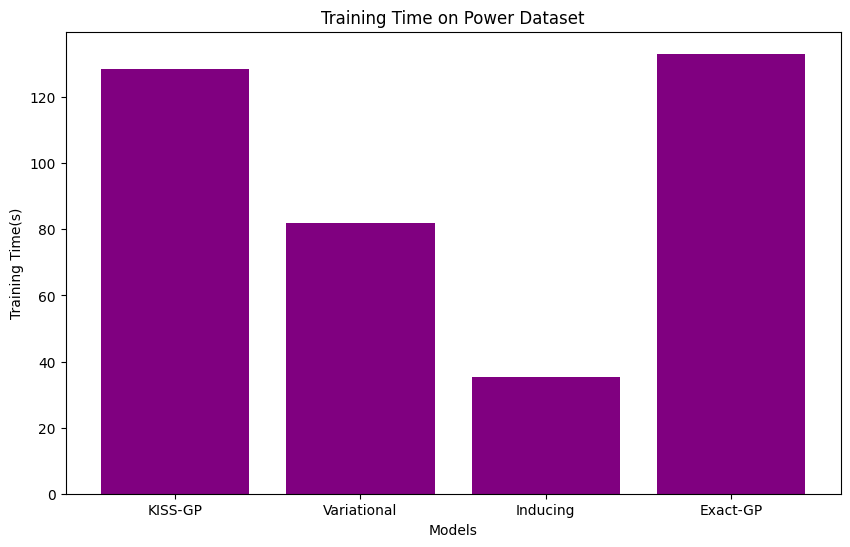

In [17]:
# Training times
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
times_power = [train_time_KISSGP_power_standardized, train_time_variational_power_standardized, train_time_inducing_power_standardized, train_time_exact_power_standardized]
plot_bar(models, times_power, "Training Time on Power Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

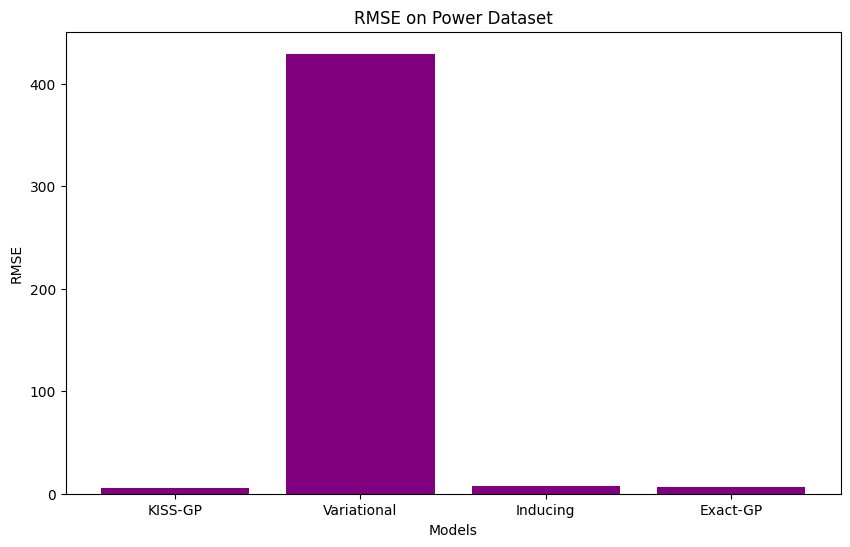

In [18]:
# RMSE
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
RMSE_power = [RMSE_KISSGP_power_standardized, RMSE_variational_power_standardized, RMSE_inducing_power_standardized, RMSE_exact_power_standardized]
plot_bar(models, RMSE_power, "RMSE on Power Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

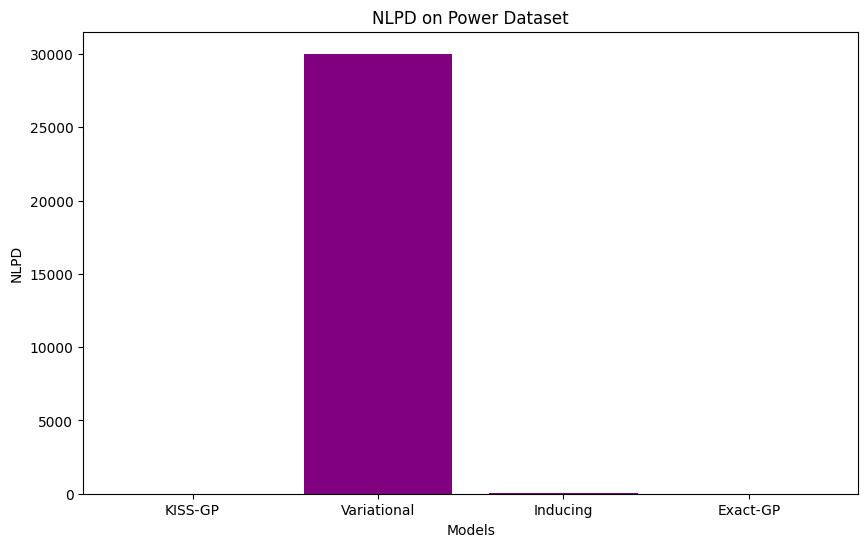

In [19]:
# NLPD
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
NLPD_power = [NLPD_KISSGP_power_standardized, NLPD_variational_power_standardized, NLPD_inducing_power_standardized, NLPD_exact_power_standardized]
plot_bar(models, NLPD_power, "NLPD on Power Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

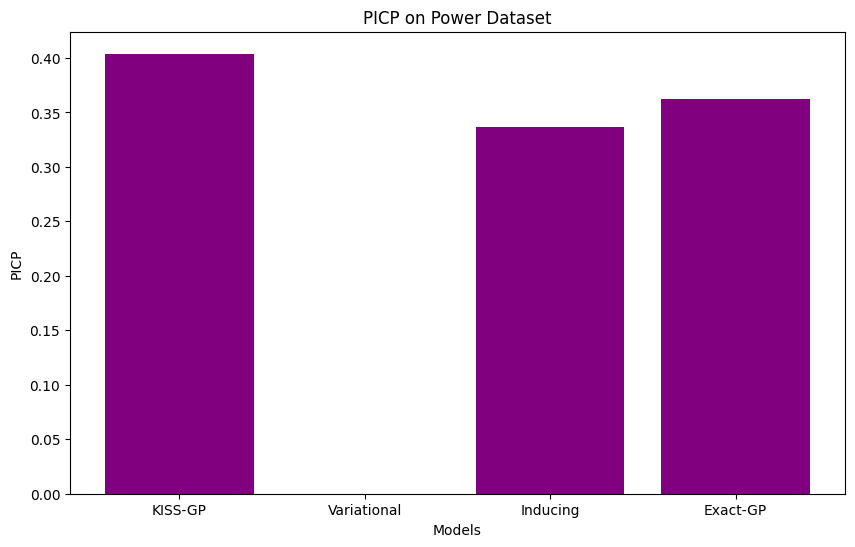

In [20]:
# PICP
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
PICP_power = [PICP_KISSGP_power_standardized, PICP_variational_power_standardized, PICP_inducing_power_standardized, PICP_exact_power_standardized]
plot_bar(models, PICP_power, "PICP on Power Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb

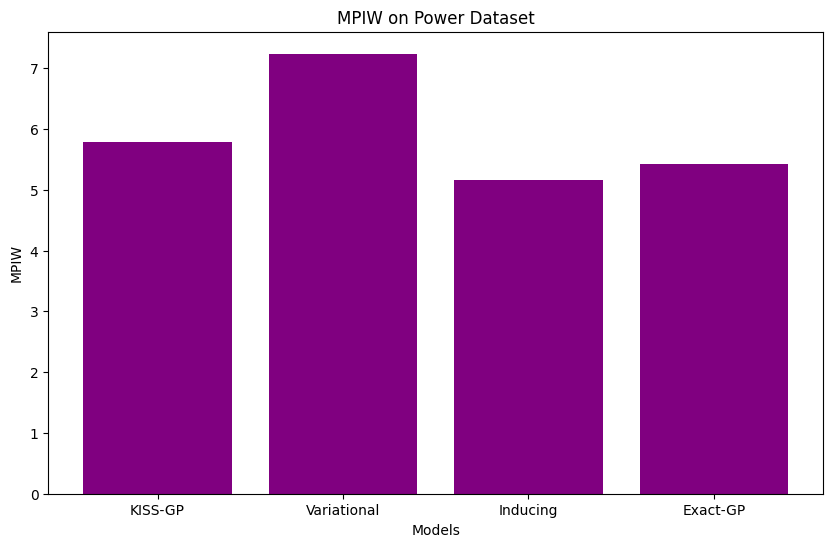

In [21]:
# MPIW
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
MPIW_power = [MPIW_KISSGP_power_standardized, MPIW_variational_power_standardized, MPIW_inducing_power_standardized, MPIW_exact_power_standardized]
plot_bar(models, MPIW_power, "MPIW on Power Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

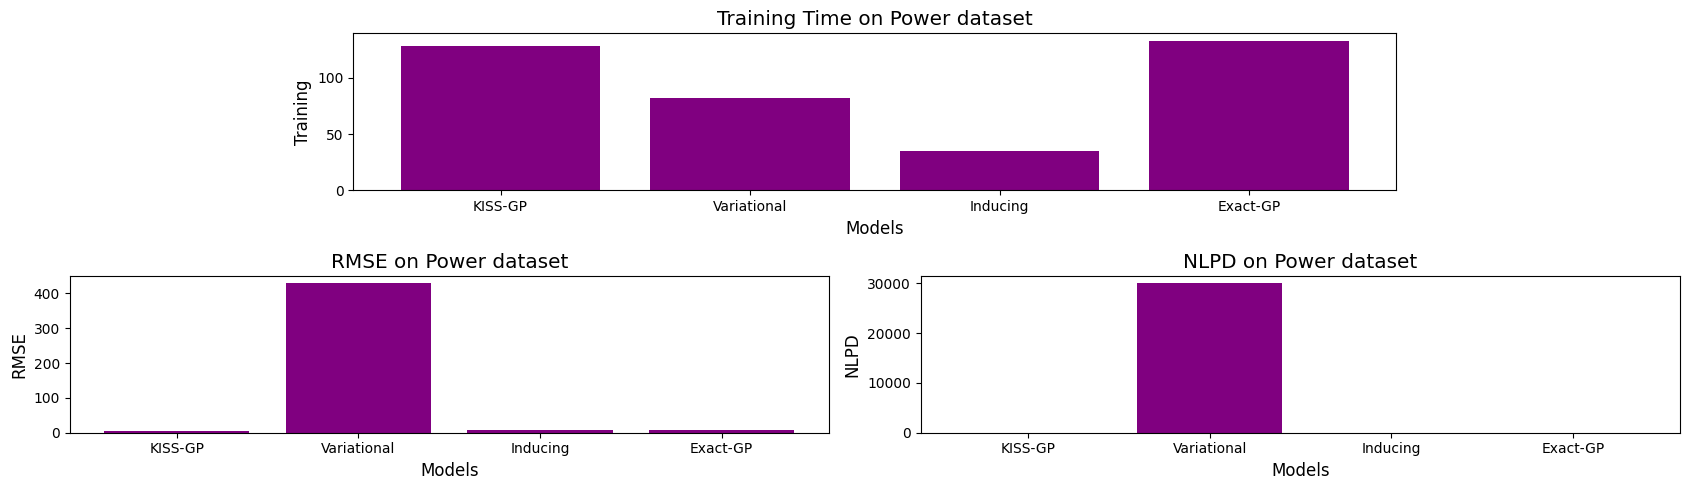

In [22]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 1:5])
ax2 = fig.add_subplot(gs[1, 0:3])
ax3 = fig.add_subplot(gs[1, 3:6])


axes = [ax1, ax2, ax3]  # List of axes
data = [times_power, RMSE_power, NLPD_power]
titles = ["Training Time on Power dataset", "RMSE on Power dataset", "NLPD on Power dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_power1.pdf")
plt.show()

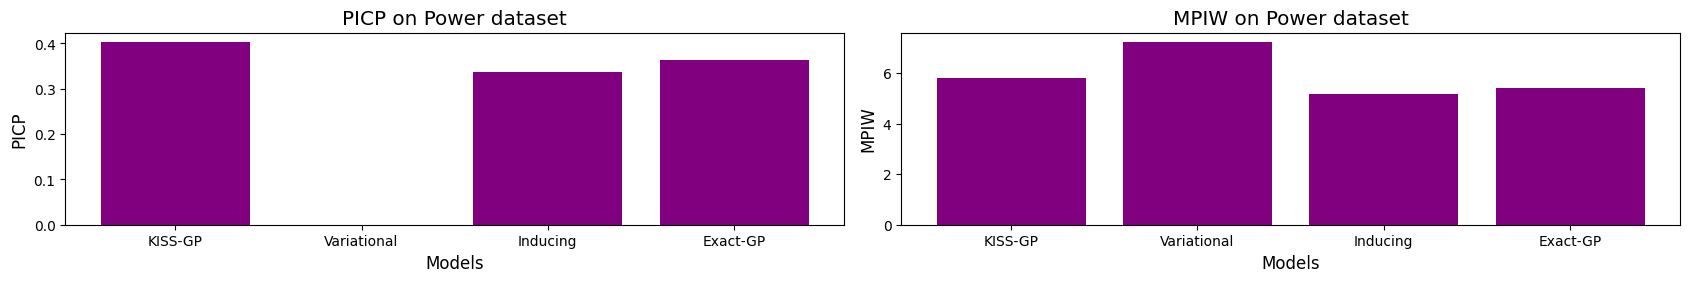

In [23]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3:6])



axes = [ax1, ax2]  # List of axes
data = [PICP_power, MPIW_power]
titles = ["PICP on Power dataset", "MPIW on Power dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_power2.pdf")
plt.show()

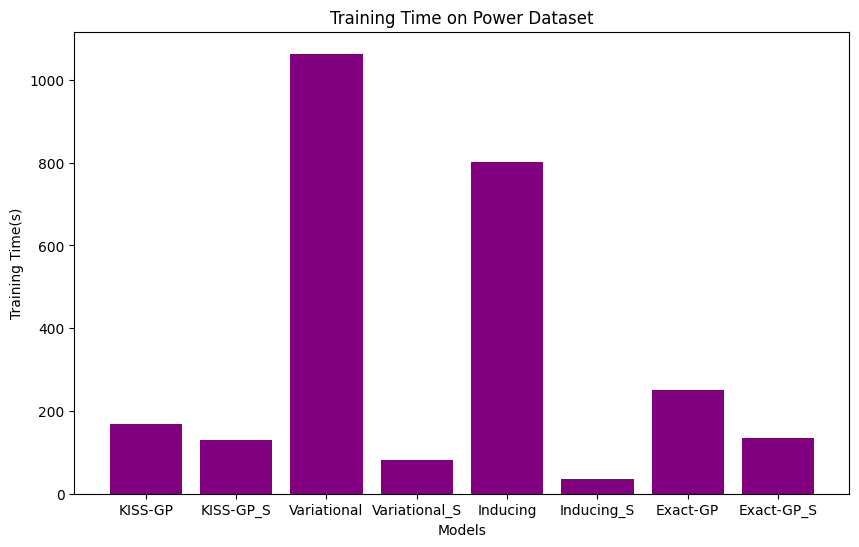

In [24]:
# Standardized or not?
# Training Time
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
time_compare = [train_time_KISSGP_power, train_time_KISSGP_power_standardized,
                train_time_variational_power, train_time_variational_power_standardized,
                train_time_inducing_power, train_time_inducing_power_standardized,
                train_time_exact_power, train_time_exact_power_standardized]
plot_bar(models_compare, time_compare, "Training Time on Power Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

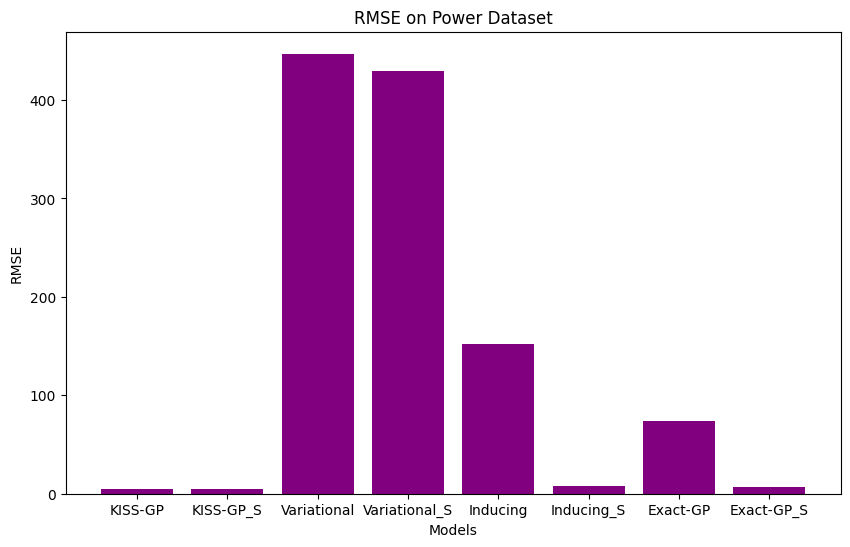

In [25]:
# Standardized or not?
# RMSE
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
RMSE_compare = [RMSE_KISSGP_power, RMSE_KISSGP_power_standardized,
                RMSE_variational_power, RMSE_variational_power_standardized,
                RMSE_inducing_power, RMSE_inducing_power_standardized,
                RMSE_exact_power,RMSE_exact_power_standardized]
plot_bar(models_compare, RMSE_compare, "RMSE on Power Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

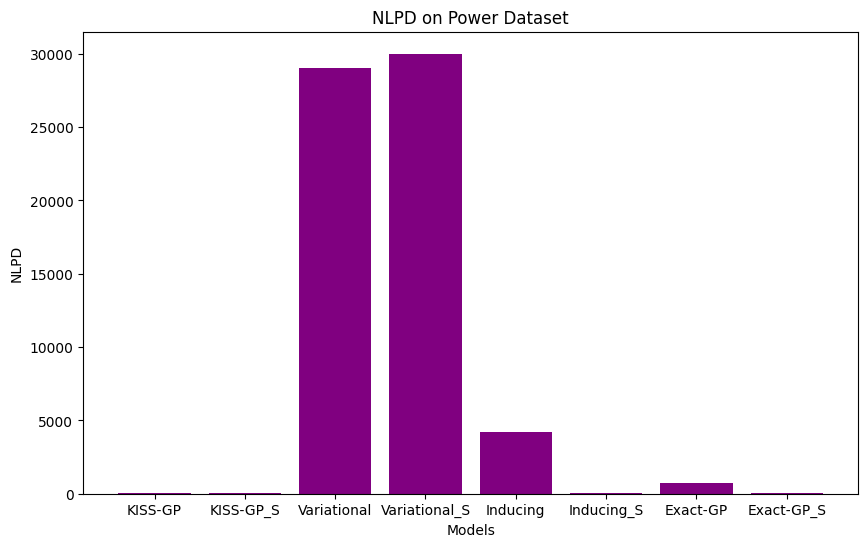

In [26]:
# Standardized or not?
# NLPD
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
NLPD_compare = [NLPD_KISSGP_power, NLPD_KISSGP_power_standardized,
                NLPD_variational_power, NLPD_variational_power_standardized,
                NLPD_inducing_power, NLPD_inducing_power_standardized,
                NLPD_exact_power, NLPD_exact_power_standardized]
plot_bar(models_compare, NLPD_compare, "NLPD on Power Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

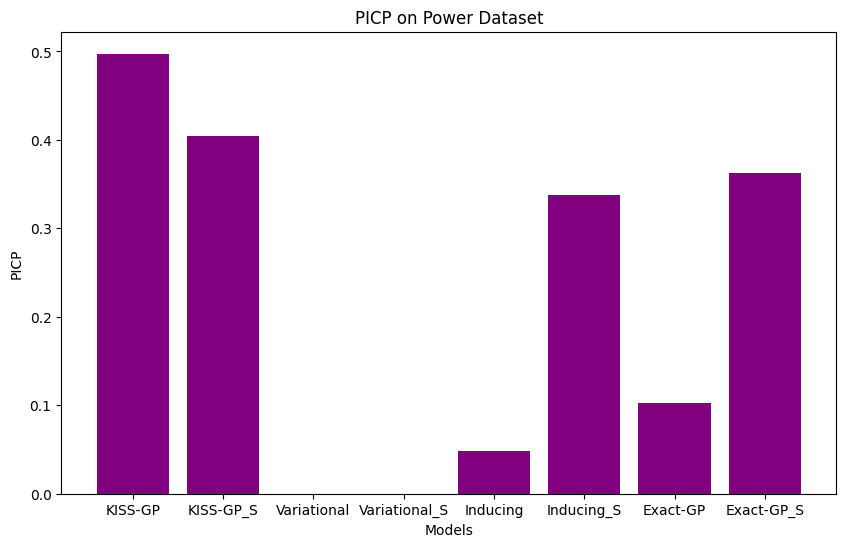

In [27]:
# Standardized or not?
# PICP
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
PICP_compare = [PICP_KISSGP_power, PICP_KISSGP_power_standardized,
                PICP_variational_power, PICP_variational_power_standardized,
                PICP_inducing_power, PICP_inducing_power_standardized,
                PICP_exact_power, PICP_exact_power_standardized]
plot_bar(models_compare, PICP_compare, "PICP on Power Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb

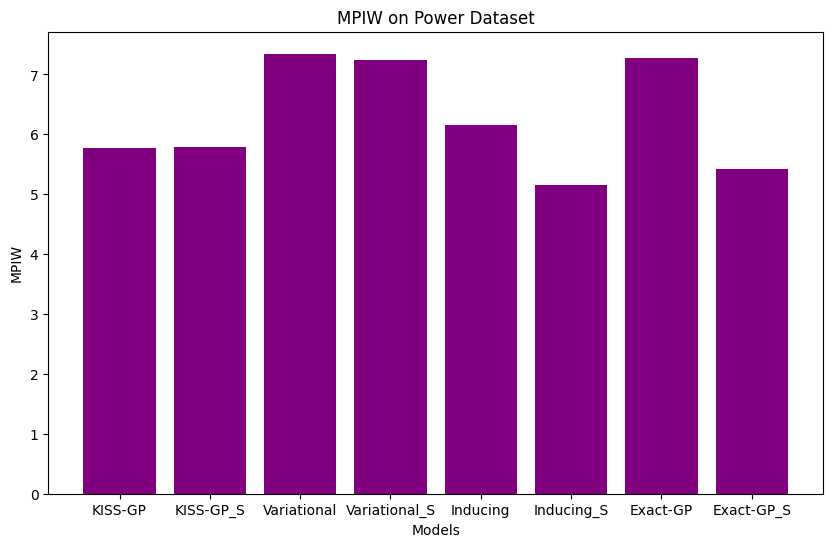

In [28]:
# Standardized or not?
# MPIW
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
MPIW_compare = [MPIW_KISSGP_power, MPIW_KISSGP_power_standardized,
                MPIW_variational_power, MPIW_variational_power_standardized,
                MPIW_inducing_power, MPIW_inducing_power_standardized,
                MPIW_exact_power, MPIW_exact_power_standardized]
plot_bar(models_compare, MPIW_compare, "MPIW on Power Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

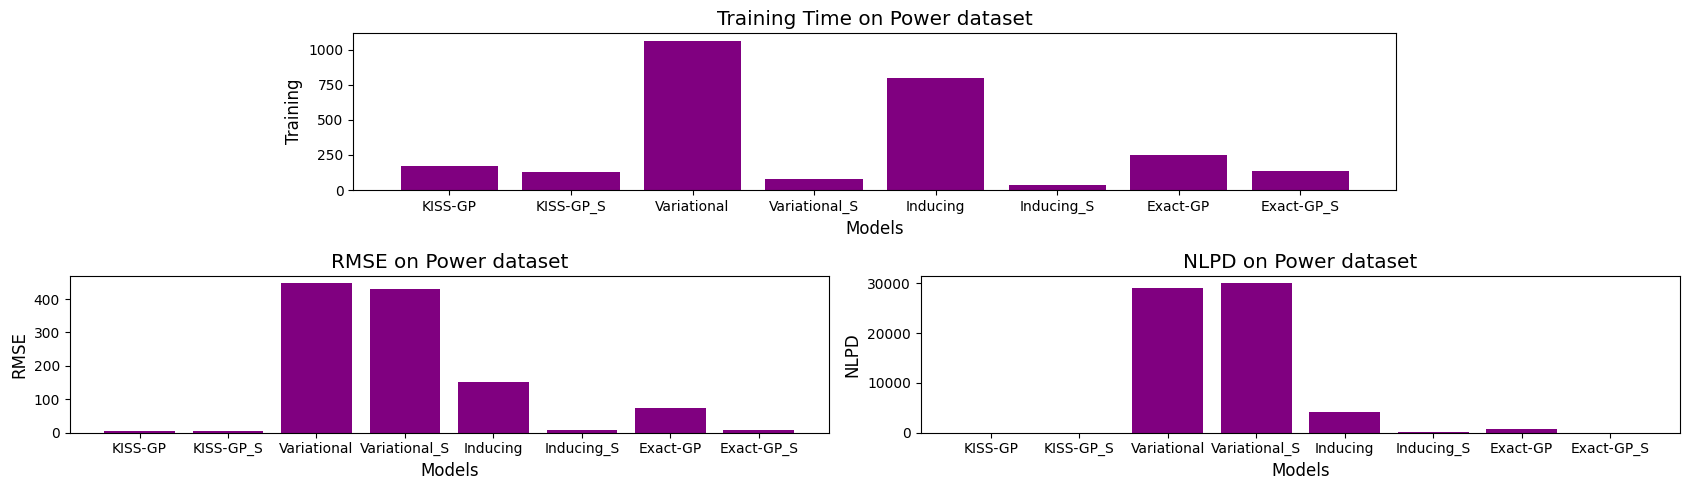

In [30]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 1:5])
ax2 = fig.add_subplot(gs[1, 0:3])
ax3 = fig.add_subplot(gs[1, 3:6])


axes = [ax1, ax2, ax3]  # List of axes
data = [time_compare, RMSE_compare, NLPD_compare]
titles = ["Training Time on Power dataset", "RMSE on Power dataset", "NLPD on Power dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models_compare, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_power_compare1.pdf")
plt.show()

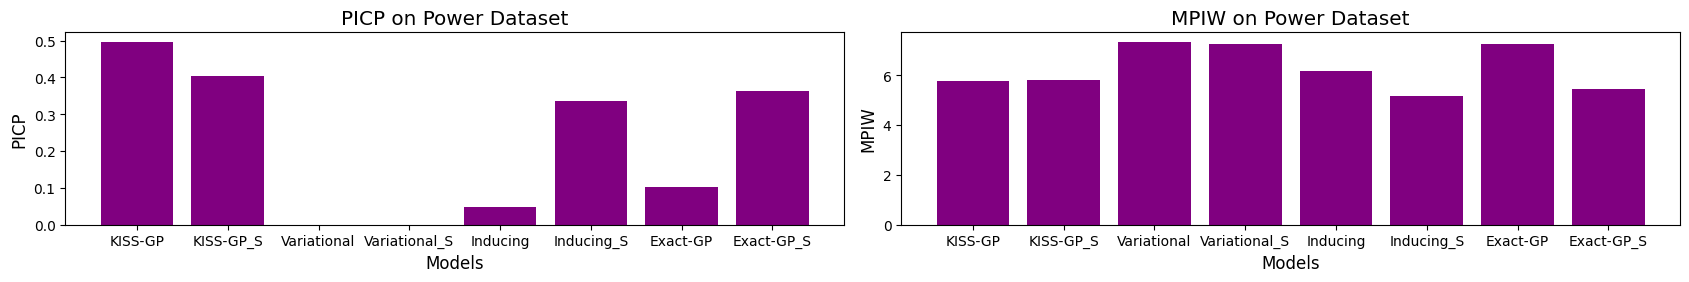

In [31]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3:6])


axes = [ax1, ax2]  # List of axes
data = [PICP_compare, MPIW_compare]
titles = ["PICP on Power Dataset", "MPIW on Power Dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models_compare, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_power_compare2.pdf")
plt.show()